
<center><H2>EE782 Advanced machine Learning </H2>
<H2>Project - Assessing Trust Level of a Driverless
Car Using Deep Learning</H2></center>

<H3>Team Members</H3>

- **Pullabhotla Bhuvana Chandra - 200070063**

- **Seepana Venkata Sai Siddartha - 200070074**



In [13]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


# Deep Models

Defining a class Deep_Models for initiating all the necessary functions , updating parameters, building DNN models, hidden layers inside it

In [14]:
# Importing necessary libraries and modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.constraints import max_norm

# Defining a class for deep learning models
class Deep_Models:
    # Initializing the class with default parameters
    def __init__(self, name):
        self.name = name
        self.model = Sequential()
        self.estimators = []
        self.hidden_layers = [100, 100, 100]
        self.input_dm = 1
        self.activation_fn = ['relu']
        self.k_fold = 10
        self.loss = 'binary_crossentropy'
        self.optimizer = 'adam'
        self.model_type = 'classifier'
        self.no_of_output = 1
        self.metrics = ['accuracy']
        self.sample_weight = None
        self.dropout_spec = [0.2, 0.2, 0.2]

    # Method to get the name of the model
    def get_name(self):
        return self.name

    # Method to get the activation function based on position
    def get_activation_fn(self, activation_fn, pos):
        if len(activation_fn) - 2 < pos:
            return activation_fn[-2]
        else:
            return activation_fn[pos]

    # Method to update model parameters
    def update_parameters(self, param):
        self.hidden_layers = param['hidden_layers']
        self.input_dm = param['input_dm']
        self.activation_fn = param['activation_fn']
        self.k_fold = param['k_fold']
        self.loss = param['loss']
        self.optimizer = param['optimizer']
        self.model_type = param['model_type']
        self.no_of_output = param['no_of_output']
        self.metrics = param['metrics']
        self.sample_weight = param['sample_weight']
        self.dropout_spec = param['dropout_spec']

    # Method to update model parameters with class weights
    def update_parameters_class_Weight(self, param):
        self.update_parameters(param)
        self.class_weight = param['class_weight']

    # Method to build the neural network model
    def build_model(self):
        # Iterating through hidden layers and adding Dense and Dropout layers
        for hl in self.hidden_layers:
            if self.hidden_layers.index(hl) == 0:  # Adding the very first hidden layer
                self.model.add(Dense(hl, input_dim=self.input_dm, kernel_initializer='normal', activation=self.activation_fn[0]))
            else:
                self.model.add(Dense(hl, kernel_initializer='normal', activation=self.get_activation_fn(self.activation_fn, self.hidden_layers.index(hl))))
                self.model.add(Dropout(self.dropout_spec[self.hidden_layers.index(hl)]))

        # Adding the output layer
        self.model.add(Dense(self.no_of_output, kernel_initializer='normal', activation=self.activation_fn[-1]))

        # Compiling the model with specified loss, optimizer, and metrics
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)

        return self.model

    # Method to tune the model by adjusting dropout rates and weight constraints
    def tune_model_Dropout(self, dropout_rate=0.0, weight_constraint=0):
        # Iterating through hidden layers and adding Dense and Dropout layers with tuning
        for hl in self.hidden_layers:
            if self.hidden_layers.index(hl) == 0:  # Adding the very first hidden layer
                self.model.add(Dense(hl, input_dim=self.input_dm, kernel_initializer='normal', activation=self.activation_fn[0], kernel_constraint=max_norm(weight_constraint)))
                self.model.add(Dropout(dropout_rate))
            else:
                self.model.add(Dense(hl, kernel_initializer='normal', activation=self.get_activation_fn(self.activation_fn, self.hidden_layers.index(hl))))
                self.model.add(Dropout(dropout_rate))

        # Adding the output layer
        self.model.add(Dense(self.no_of_output, kernel_initializer='normal', activation=self.activation_fn[-1]))

        # Compiling the model with specified loss, optimizer, and metrics
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)

        return self.model

    # Method to build the model and create a pipeline with an estimator
    def build_estimator(self):
        self.estimators.append(('mlp', self.build_model()))
        self.pipeline = Pipeline(self.estimators)

    # Method for k-fold cross-validation and printing results
    def kfold_CVS(self, X, Y):
        kfold = KFold(n_splits=10)
        results = cross_val_score(self.pipeline, X, Y, cv=kfold)
        print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

    # Method for training and evaluating the model without class weights
    def DNN_Models(self, X, Y, **param):
        self.update_parameters(param)
        self.build_estimator()
        if self.k_fold > 0:
            self.kfold_CVS(X, Y)
        print(self.sample_weight)
        self.pipeline.fit(X, Y, **{'mlp__sample_weight': self.sample_weight})

        return self.pipeline

    # Method for training and evaluating the model with class weights
    def DNN_Models_Class_Weight(self, X, Y, **param):
        self.update_parameters_class_Weight(param)
        self.build_estimator()
        if self.k_fold > 0:
            self.kfold_CVS(X, Y)
        print(self.sample_weight)
        self.pipeline.fit(X, Y, **{'mlp__class_weight': self.sample_weight})

        return self.pipeline

    # Special method for calling the instance
    def __call__(self):
        print(f"Deep_Models instance '{self.name}' is called.")
        return self


# Model_Evaluation_ROC

Creating a class Model_Evaluation_ROC to plot the ROC curve (Receiver Operating characteristic) for all the final results individually and also comparing two different results obtained by training using SVM,LSTM

In [15]:
# Import necessary libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
import string
import numpy as np
import os

# Define a class for ROC curve generation and comparison
class Model_Evaluation_ROC:
    def __init__(self, name):
        self.name = name

    # Generate ROC curves for each output in a DataFrame and display them
    def ROC_Curve_Generator(self, df, no_of_output, offset):
        for x in range(no_of_output):
            plt.figure()
            # plot no skill roc curve
            plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
            # calculate roc curve for model
            fpr, tpr, _ = roc_curve(df.iloc[:, x], df.iloc[:, x+offset])
            # plot model roc curve
            plt.plot(fpr, tpr, marker='.', label='ROC_DNN_'+df.columns[x])
            # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # show the legend
            plt.legend()
            # show the plot
            plt.show()

    # Generate ROC curves for each output in a DataFrame and display them in subplots
    def ROC_Curve_Generator_Subplot(self, df, no_of_output, offset):
        fig, a = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))
        props = dict(boxstyle='square', facecolor='white', alpha=0.5)

        for x in range(no_of_output):
            # plot no skill roc curve
            a[0, x].plot([0, 1], [0, 1], linestyle='--', label='No_Skill_' + df.columns[x])
            # calculate roc curve for model
            fpr, tpr, _ = roc_curve(df.iloc[:, x], df.iloc[:, x+offset])
            # plot model roc curve
            a[0, x].plot(fpr, tpr, marker='.', label='ROC_'+df.columns[x])
            # axis labels
            a[0, x].set_xlabel('False Positive Rate', fontsize=15)
            a[0, x].set_ylabel('True Positive Rate', fontsize=15)
            # show the legend
            a[0, x].legend(fontsize=15)
            a[0, x].text(0.6, 0.4, "AUC = " + "{:.2f}".format(round(roc_auc_score(df.iloc[:, x], df.iloc[:, x+(offset*2)]), 2)), transform=a[0, x].transAxes, fontsize=14, verticalalignment='top', bbox=props)
            a[0, x].text(0.5, -0.3, "("+string.ascii_lowercase[x]+")", transform=a[0, x].transAxes, size=20)

        # Save the plot to a file
        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/ROC_AUC_Curve_'+str(no_of_output)+'.png'
        plt.savefig(filename, format="png", bbox_inches='tight', figsize=(9, 11))
        # Show the plot
        plt.show()

    # Generate ROC curves for each output in DataFrames and compare them in subplots
    def ROC_Curve_Generator_Subplot_Comparison(self, df, df_SVM, df_LSTM, no_of_output, offset):
        fig, a = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))

        for x in range(no_of_output):
            # calculate roc curve for DNN model
            fpr, tpr, _ = roc_curve(df.iloc[:, x], df.iloc[:, x+offset])
            # plot DNN model roc curve
            a[0, x].plot(fpr, tpr, marker='.', label='ROC_'+df.columns[x]+'_DNN')

            # calculate roc curve for SVM model
            fpr_SVC, tpr_SVC, _ = roc_curve(df_SVM.iloc[:, x], df_SVM.iloc[:, x+offset])
            # plot SVM model roc curve
            a[0, x].plot(fpr_SVC, tpr_SVC, marker='.', label='ROC_'+df.columns[x]+'_SVM')

            # calculate roc curve for LSTM model
            fpr_LSTM, tpr_LSTM, _ = roc_curve(df_LSTM.iloc[:, x], df_LSTM.iloc[:, x+offset])
            # plot LSTM model roc curve
            a[0, x].plot(fpr_LSTM, tpr_LSTM, marker='.', label='ROC_'+df.columns[x]+'_LSTM')

            # axis labels
            a[0, x].set_xlabel('False Positive Rate', fontsize=15)
            a[0, x].set_ylabel('True Positive Rate', fontsize=15)
            # show the legend
            a[0, x].legend(fontsize=12)
            a[0, x].text(0.55, 0.65, "AUC_DNN = " + "{:.2f}".format(round(roc_auc_score(df.iloc[:, x], df.iloc[:, x+(offset*2)]), 2)), transform=a[0, x].transAxes, fontsize=14, verticalalignment='top')
            a[0, x].text(0.55, 0.55, "AUC_SVM = " + "{:.2f}".format(round(roc_auc_score(df_SVM.iloc[:, x], df_SVM.iloc[:, x+(offset*2)]), 2)), transform=a[0, x].transAxes, fontsize=14, verticalalignment='top')
            a[0, x].text(0.55, 0.45, "AUC_LSTM = " + "{:.2f}".format(round(roc_auc_score(df_LSTM.iloc[:, x], df_LSTM.iloc[:, x+(offset*2)]), 2)), transform=a[0, x].transAxes, fontsize=14, verticalalignment='top')
            a[0, x].text(0.5, -0.3, "("+string.ascii_lowercase[x]+")", transform=a[0, x].transAxes, size=20)

        # Save the plot to a file
        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/ROC_AUC_Curve_'+str(no_of_output)+'.png'
        plt.savefig(filename, format="png", bbox_inches='tight')
        # Show the plot
        plt.show()


# Model_Evaluation_PR

Creating a class Model_Evaluation_PR to plot the Precision vc Recall plots for all the final results individually and also comparing two different results obtained by training using SVM,LSTM

In [16]:
# Define a class for precision-recall curve generation and comparison
class Model_Evaluation_PR:
    def __init__(self, name):
        self.name = name

    # Generate precision-recall curves for each output in a DataFrame and display them
    def PR_Curve_Generator(self, df, no_of_output, offset, no_skill_df, nsd_offset):
        for x in range(no_of_output):
            print(f'Average Precision Score for {df.columns[x]} is {average_precision_score(df.iloc[:, x], df.iloc[:, x+offset])}')

            plt.figure()

            y = no_skill_df.iloc[:, x + nsd_offset]
            no_skill = len(y[y==1]) / len(y)
            # plot the no skill precision-recall curve
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

            precision, recall, _ = precision_recall_curve(df.iloc[:, x], df.iloc[:, x+offset])
            # plot the model precision-recall curve
            plt.plot(recall, precision, marker='.', label='PR_DNN_'+df.columns[x])
            # axis labels
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # show the legend
            plt.legend()
            # show the plot
            plt.show()

    # Generate precision-recall curves for each output in a DataFrame and display them in subplots
    def PR_Curve_Generator_Subplot(self, df, no_of_output, offset, no_skill_df, nsd_offset):
        fig, a = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))
        props = dict(boxstyle='square', facecolor='white', alpha=0.5)

        for x in range(no_of_output):
            print(f'Average Precision Score for {df.columns[x]} is {average_precision_score(df.iloc[:, x], df.iloc[:, x+offset])}')

            y = no_skill_df.iloc[:, x + nsd_offset]
            no_skill = len(y[y==1]) / len(y)
            # plot the no skill precision-recall curve
            a[0, x].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

            precision, recall, _ = precision_recall_curve(df.iloc[:, x], df.iloc[:, x+offset])
            # plot the model precision-recall curve
            a[0, x].plot(recall, precision, marker='.', label='PR_DNN_'+df.columns[x])
            # axis labels
            a[0, x].set_xlabel('Recall', fontsize=15)
            a[0, x].set_ylabel('Precision', fontsize=15)
            # show the legend
            a[0, x].legend(fontsize=13)

            a[0, x].text(0.1, 0.3, "Average Precision = " + "{:.2f}".format(round(average_precision_score(df.iloc[:, x], df.iloc[:, x+offset]), 2)), transform=a[0, x].transAxes, fontsize=14, verticalalignment='top', bbox=props)
            a[0, x].text(0.5, -0.3, "("+string.ascii_lowercase[x]+")", transform=a[0, x].transAxes, size=20)

        # Save the plot to a file
        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/PR_Curve_'+str(no_of_output)+'.png'
        #os.makedirs(filename, exist_ok=True)
        plt.savefig(filename, format="png", bbox_inches='tight')

        # show the plot
        plt.show()

    # Generate precision-recall curves for each output in DataFrames and compare them in subplots
    def PR_Curve_Generator_Subplot_Comparison(self, df, df_SVM, df_LSTM, no_of_output, offset, no_skill_df, nsd_offset):
        fig, a = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))

        for x in range(no_of_output):
            print(f'Average Precision Score for {df.columns[x]} is {average_precision_score(df.iloc[:, x], df.iloc[:, x+offset])}')

            precision, recall, _ = precision_recall_curve(df.iloc[:, x], df.iloc[:, x+offset])
            # plot the model precision-recall curve
            a[0, x].plot(recall, precision, marker='.', label='PR_'+df.columns[x]+'_DNN')

            precision_SVC, recall_SVC, _ = precision_recall_curve(df_SVM.iloc[:, x], df_SVM.iloc[:, x+offset])
            a[0, x].plot(recall_SVC, precision_SVC, marker='.', label='PR_'+df.columns[x]+'_SVM')

            precision_LSTM, recall_LSTM, _ = precision_recall_curve(df_LSTM.iloc[:, x], df_LSTM.iloc[:, x+offset])
            a[0, x].plot(recall_LSTM, precision_LSTM, marker='.', label='PR_'+df.columns[x]+'_LSTM')

            # axis labels
            a[0, x].set_xlabel('Recall', fontsize=15)
            a[0, x].set_ylabel('Precision', fontsize=15)
            # show the legend
            a[0, x].legend(fontsize=12, loc='lower right')

            a[0, x].set_xlim(0.01, 1.0)
            a[0, x].set_ylim(-0.1, 1.0)

            a[0, x].text(0.05, 0.58, "Average Precision (DNN) = " + "{:.2f}".format(round(average_precision_score(df.iloc[:, x], df.iloc[:, x+offset]), 2)), transform=a[0, x].transAxes, fontsize=12, verticalalignment='top')
            a[0, x].text(0.05, 0.49, "Average Precision (SVM) = " + "{:.2f}".format(round(average_precision_score(df_SVM.iloc[:, x], df_SVM.iloc[:, x+offset]), 2)), transform=a[0, x].transAxes, fontsize=12, verticalalignment='top')
            a[0, x].text(0.05, 0.40, "Average Precision (LSTM) = " + "{:.2f}".format(round(average_precision_score(df_LSTM.iloc[:, x], df_LSTM.iloc[:, x+offset]), 2)), transform=a[0, x].transAxes, fontsize=12, verticalalignment='top')
            a[0, x].text(0.5, -0.3, "("+string.ascii_lowercase[x]+")", transform=a[0, x].transAxes, size=20)

        # Save the plot to a file
        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/PR_Curve_'+str(no_of_output)+'.png'
        #os.makedirs(filename, exist_ok=True)
        plt.savefig(filename, format="png", bbox_inches='tight')

        # show the plot
        plt.show()


# Model_Evaluation_metrics

Model for printing the metrics obtanieed by testing the test data and obtain the final classificarion results- Accuracy, Precision, F1 score, ROC AUC curve, confusion matrix

In [17]:
class Model_Evaluation_metrics:
    def __init__(self, name):
        self.name = name
    def metrics_printer(self, df, no_of_output, offset):
        for x in range(no_of_output):
            print(f'Accuracy Score for {df.columns[x]} is {accuracy_score(df.iloc[:,x], df.iloc[:,x+offset])}')
            print(f'Precision Score for {df.columns[x]} is {precision_score(df.iloc[:,x], df.iloc[:,x+offset])}')
            print(f'Recall Score for {df.columns[x]} is {recall_score(df.iloc[:,x], df.iloc[:,x+offset])}')
            print(f'F1 Score for {df.columns[x]} is {f1_score(df.iloc[:,x], df.iloc[:,x+offset])}')
            print(f'ROC AUC Score for {df.columns[x]} is {roc_auc_score(df.iloc[:,x], df.iloc[:,x+offset])}')
            print(f'Confusion Matrix for {df.columns[x]} is {confusion_matrix(df.iloc[:,x], df.iloc[:,x+offset])}')


    def metrics_file_writer(self, file_name, df, no_of_output, offset):
        with open(file_name, 'w') as f:
            for x in range(no_of_output):
                print(f'Accuracy Score for {df.columns[x]} is {accuracy_score(df.iloc[:,x], df.iloc[:,x+offset])}', file = f)
                print(f'Precision Score for {df.columns[x]} is {precision_score(df.iloc[:,x], df.iloc[:,x+offset])}', file = f)
                print(f'Recall Score for {df.columns[x]} is {recall_score(df.iloc[:,x], df.iloc[:,x+offset])}', file = f)
                print(f'F1 Score for {df.columns[x]} is {f1_score(df.iloc[:,x], df.iloc[:,x+offset])}', file = f)
                print(f'ROC AUC Score for {df.columns[x]} is {roc_auc_score(df.iloc[:,x], df.iloc[:,x+offset])}', file = f)
                print(f'Confusion Matrix for {df.columns[x]} is {confusion_matrix(df.iloc[:,x], df.iloc[:,x+offset])}', file = f)

    def figure_generator_single_output(self, df, no_of_output, offset, no_skill_df, nsd_offset):
        fig,a =  plt.subplots(1, 2, squeeze=False, figsize=(18,4))
        props = dict(boxstyle='square', facecolor='white', alpha=0.5)

        x = 0

        # plot no skill roc curve
        a[0, 0].plot([0, 1], [0, 1], linestyle='--', label='No_Skill_' + df.columns[x])
        # calculate roc curve for model
        fpr, tpr, _ = roc_curve(df.iloc[:,x], df.iloc[:, x+offset])
        # plot model roc curve
        a[0, 0].plot(fpr, tpr, marker='.', label='ROC_'+df.columns[x])
        # axis labels
        a[0, 0].set_xlabel('False Positive Rate', fontsize = 15)
        a[0, 0].set_ylabel('True Positive Rate', fontsize = 15)
        # show the legend
        a[0, 0].legend(fontsize = 15)
        a[0, 0].text(0.6, 0.4, "AUC = " + "{:.2f}".format(round(roc_auc_score(df.iloc[:,x], df.iloc[:,x+(offset*2)]), 2)), transform=a[0, 0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        a[0, 0].text(0.5, -0.3, "("+string.ascii_lowercase[x]+")", transform=a[0, 0].transAxes, size=20)
        a[0, 0].set_xlim(-0.004, 1.0)
        a[0, 0].set_ylim(-0.01, 1.01)

        print(f'Average Precision Score for {df.columns[x]} is {average_precision_score(df.iloc[:,x], df.iloc[:, x+offset])}')

        y = no_skill_df.iloc[:, x + nsd_offset]
        no_skill = len(y[y==1]) / len(y)
        # plot the no skill precision-recall curve
        a[0, 1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

        precision, recall, _ = precision_recall_curve(df.iloc[:,x], df.iloc[:, x+offset])
        # plot the model precision-recall curve
        a[0, 1].plot(recall, precision, marker='.', label='PR_DNN_'+df.columns[x])
        # axis labels
        a[0, 1].set_xlabel('Recall', fontsize = 15)
        a[0, 1].set_ylabel('Precision', fontsize = 15)
        # show the legend
        a[0, 1].legend(fontsize = 13)

        a[0, 1].set_xlim(0.0, 1.0)
        a[0, 1].set_ylim(0.4, 1.01)

        a[0, 1].text(0.1, 0.3, "Average Precision = " + "{:.2f}".format(round(average_precision_score(df.iloc[:,x], df.iloc[:, x+offset]), 2)), transform=a[0, 1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        a[0, 1].text(0.5, -0.3, "("+string.ascii_lowercase[1]+")", transform=a[0, 1].transAxes, size=20)

        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/ROC_PR_Curve_'+str(no_of_output)+'.png'
        #os.makedirs(filename, exist_ok=True)
        plt.savefig(filename, format="png", bbox_inches='tight')

        # show the plot
        plt.show()

    def figure_generator_single_output_comparison(self, df, df_SVM, df_LSTM, no_of_output, offset, no_skill_df, nsd_offset):
        fig,a =  plt.subplots(1, 2, squeeze=False, figsize=(18,4))
        props = dict(boxstyle='square', facecolor='white', alpha=0.5)

        x = 0

        fpr, tpr, _ = roc_curve(df.iloc[:,x], df.iloc[:, x+offset])
        # plot model roc curve
        a[0, 0].plot(fpr, tpr, marker='.', label='ROC_DNN')
        # axis labels

        fpr_SVM, tpr_SVM, _ = roc_curve(df_SVM.iloc[:,x], df_SVM.iloc[:, x+offset])
        # plot model roc curve
        a[0, 0].plot(fpr_SVM, tpr_SVM, marker='.', label='ROC_SVM')


        fpr_LSTM, tpr_LSTM, _ = roc_curve(df_LSTM.iloc[:,x], df_LSTM.iloc[:, x+offset])
        # plot model roc curve
        a[0, 0].plot(fpr_LSTM, tpr_LSTM, marker='.', label='ROC_LSTM')

        # axis labels


        a[0, 0].set_xlabel('False Positive Rate', fontsize = 15)
        a[0, 0].set_ylabel('True Positive Rate', fontsize = 15)
        # show the legend
        a[0, 0].legend(fontsize = 15)
        a[0, 0].text(0.6, 0.5, "AUC_DNN = " + "{:.2f}".format(round(roc_auc_score(df.iloc[:,x], df.iloc[:,x+(offset*2)]), 2)), transform=a[0, 0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        a[0, 0].text(0.6, 0.4, "AUC_SVM = " + "{:.2f}".format(round(roc_auc_score(df_SVM.iloc[:,x], df_SVM.iloc[:,x+(offset*2)]), 2)), transform=a[0, 0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        a[0, 0].text(0.6, 0.3, "AUC_LSTM = " + "{:.2f}".format(round(roc_auc_score(df_LSTM.iloc[:,x], df_LSTM.iloc[:,x+(offset*2)]), 2)), transform=a[0, 0].transAxes, fontsize=14, verticalalignment='top', bbox=props)


        a[0, 0].text(0.5, -0.3, "("+string.ascii_lowercase[x]+")", transform=a[0, 0].transAxes, size=20)

        a[0, 0].set_xlim(-0.004, 1.0)
        a[0, 0].set_ylim(-0.01, 1.01)

        print(f'Average Precision Score for {df.columns[x]} is {average_precision_score(df.iloc[:,x], df.iloc[:, x+offset])}')

        precision, recall, _ = precision_recall_curve(df.iloc[:,x], df.iloc[:, x+offset])
        # plot the model precision-recall curve
        a[0, 1].plot(recall, precision, marker='.', label='PR_DNN')

        precision_SVM, recall_SVM, _ = precision_recall_curve(df_SVM.iloc[:,x], df_SVM.iloc[:, x+offset])
        # plot the model precision-recall curve
        a[0, 1].plot(recall_SVM, precision_SVM, marker='.', label='PR_SVM')

        precision_LSTM, recall_LSTM, _ = precision_recall_curve(df_LSTM.iloc[:,x], df_LSTM.iloc[:, x+offset])
        # plot the model precision-recall curve
        a[0, 1].plot(recall_LSTM, precision_LSTM, marker='.', label='PR_LSTM')

        # axis labels
        a[0, 1].set_xlabel('Recall', fontsize = 15)
        a[0, 1].set_ylabel('Precision', fontsize = 15)
        # show the legend
        a[0, 1].legend(fontsize = 13)

        a[0, 1].set_xlim(0.05, 1.0)
        a[0, 1].set_ylim(0.0, 1.01)

        a[0, 1].text(0.4, 0.4, "Average Precision (DNN) = " + "{:.2f}".format(round(average_precision_score(df.iloc[:,x], df.iloc[:, x+offset]), 2)), transform=a[0, 1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        a[0, 1].text(0.4, 0.3, "Average Precision (SVM) = " + "{:.2f}".format(round(average_precision_score(df_SVM.iloc[:,x], df_SVM.iloc[:, x+offset]), 2)), transform=a[0, 1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        a[0, 1].text(0.4, 0.2, "Average Precision (LSTM) = " + "{:.2f}".format(round(average_precision_score(df_LSTM.iloc[:,x], df_LSTM.iloc[:, x+offset]), 2)), transform=a[0, 1].transAxes, fontsize=14, verticalalignment='top', bbox=props)

        a[0, 1].text(0.5, -0.3, "("+string.ascii_lowercase[1]+")", transform=a[0, 1].transAxes, size=20)

        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/ROC_PR_Curve_'+str(no_of_output)+'.png'
        #os.makedirs(filename, exist_ok=True)
        plt.savefig(filename, format="png", bbox_inches='tight')

        # show the plot
        plt.show()



# Model_Evaluation_boxplot

Model for plot the boxplot of the obtianed results and curves after testing the data for different methods

In [18]:
import string
import matplotlib.pyplot as plt
import numpy as np

class Model_Evaluation_boxplot:
    def __init__(self, name):
        # Constructor to initialize the name attribute
        self.name = name

    def box_plot_generator(self, df, columns, df_car, columns_car):
        # Generate box plots for predicted trustworthiness scores
        fig, axes = plt.subplots(1, 4, squeeze=False, figsize=(24, 4))
        flierprops = dict(marker='o', markerfacecolor="0.5", markersize=3,
                          linestyle='none', markeredgecolor="0.5")

        # Plotting box plot for the first set of data
        ax = (df[columns]).boxplot(by=columns[0], ax=axes.flatten()[0], fontsize=15, grid=False, widths=0.3, flierprops=flierprops)
        ax.axhline(y=0.5, color="0.5", linestyle='--', alpha=0.5)
        ax.set_xlabel('Non-Trustworthy (0) and Trustworthy(1)', fontsize=12)
        ax.set_ylabel('Predicted Trustworthiness Scores', fontsize=12)
        ax.set_title('')
        fig = np.asarray(ax).reshape(-1)[0].get_figure()
        fig.suptitle('', fontsize=1)
        ax.text(0.5, -0.3, "(" + string.ascii_lowercase[0] + ")", transform=ax.transAxes, size=20)

        # Plotting box plots for the rest of the data
        for i in range(1, 4):
            ax_C = (1 - df_car[[columns_car[i], columns_car[i + 3]]]).boxplot(by=columns_car[i], ax=axes.flatten()[i], fontsize=15, grid=False, widths=0.3, flierprops=flierprops)
            ax_C.axhline(y=0.5, color="0.5", linestyle='--', alpha=0.5)
            ax_C.set_xlabel('Non-Trustworthy (0) and Trustworthy(1)', fontsize=12)
            ax_C.set_ylabel('Predicted Trustworthiness Scores', fontsize=12)
            ax_C.set_title('')
            fig = np.asarray(ax_C).reshape(-1)[0].get_figure()
            fig.suptitle('', fontsize=1)
            ax_C.text(0.5, -0.3, "(" + string.ascii_lowercase[i] + ")", transform=ax_C.transAxes, size=20)

        filename = '/content/drive/MyDrive/ee782_project/FInal_Result_Plots/Box_Plot_All.png'
        # Uncomment the line below if you want to create the directory if it doesn't exist
        # os.makedirs(filename, exist_ok=True)
        plt.savefig(filename, format="png", bbox_inches='tight')

        plt.show()

    def __call__(self):
        # You can add any additional logic or functionality here
        print(f"Deep_Models instance '{self.name}' is called.")
        return self


# Model_Reading_Data

Model for reading the data from the files and obtaning the parameters related to the cars-Acceleration(A),Relative Distance(D),Joint impact Speed*Distance(SD),Relative Speed(RS) for all the cars which was lablled from 1 to 9. If vehicl number of a car is 9, then it forms a fresh set of data frame.

In [19]:
import pandas as pd
import numpy as np

metrics_file = "/content/drive/MyDrive/ee782_project/dataset/Metrics_File.txt"
filename_car_processed = "/content/drive/MyDrive/ee782_project/dataset/Data_Set_Car_Processed.xlsx"
filename_MOC_car = "/content/drive/MyDrive/ee782_project/dataset/Predictions_Multi_Class_Car.xlsx"
metrics_file_car = "/content/drive/MyDrive/ee782_project/dataset/Metrics_File_Car.txt"
filename_analysis = "/content/drive/MyDrive/ee782_project/dataset/Predictions_Multi_Class_Car_PR_ROC.xlsx"
filename_analysis_DNN = "/content/drive/MyDrive/ee782_project/dataset/Predictions_PR_ROC.xlsx"
filename_analysis_Keras = "/content/drive/MyDrive/ee782_project/dataset/Predictions_PR_ROC_Keras.xlsx"
filename_BC = "/content/drive/MyDrive/ee782_project/dataset/Predictions_Binary_Class.xlsx"

features = ['Flowrate', 'Speed', 'Phasetime']
data_car_columns = ['Vehicle no', 'Time 1', 'Time 2 (T1+30 sec)', 'Speed 1', 'Speed 2', 'Distance 1', 'Distance 2', 'Camera', 'Lidar', 'Radar']
target_car = ['C', 'L', 'R']
target =   ['Two_Class']
sheet_name = ['Trustworthy_Data', 'Untrustworthy_Data', 'Untrustworthy_MO']
hidden_units_spec = [1024, 512, 256]
dropout_spec = [0.5, 0.4, 0.3]

#Reading data from the file and add target columns to the file
def read_data(filename, features, target, sheet_name):
    df = pd.read_excel(filename, sheet_name = sheet_name)
    df = df[features + target]

    return df
#preparing data for training by shuffling
def prepare_data(df1, df2, Shuffle = True):
    df = df1.append(df2).reset_index(drop = True)
    if Shuffle == True:
        df = df.reindex(np.random.permutation(df.index))  # need to shuffle the data to get a mix of both classes
    return df

# Reading the data related to individual cars' speed and distance.
def read_data_car(filename_car, data_car_columns, sheet_name = 'data_car'):
    df = pd.read_excel(filename_car, sheet_name = sheet_name)
    df = df[data_car_columns]
    #A-Acceleration,D-Distance,SD-Speed*Distanc product,RS-Relative Speed
    columns = ['A1', 'D1', 'SD1', 'A2', 'D2', 'SD2', 'A3', 'RS3', 'D3', 'SD3', 'A4', 'RS4', 'D4', 'SD4',
               'A5', 'RS5', 'D5', 'SD5', 'A6', 'RS6', 'D6', 'SD6', 'A7', 'RS7', 'D7', 'SD7', 'A8', 'RS8', 'D8', 'SD8',
               'C', 'L', 'R']
    data = pd.DataFrame([], columns = columns)
    frame = []
    for x in list(df.index):
        if df.iloc[x, :]['Vehicle no'] == 9:
          # Append the frame to the new dataframe when encountering the end of data for a car
            data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
            frame = [] # Reset the frame for the next car
            continue
        # Calculate and append values of aqcceleration of car with respect to the time to the frame
        frame.append((df.iloc[x, :]['Speed 1'] - df.iloc[x, :]['Speed 2'])/0.5)

        if df.iloc[x, :]['Vehicle no'] != 1 and df.iloc[x, :]['Vehicle no'] != 2:
        #Calculate relative speed of car i with respect to its immediately preceeding car j
            rs1 = (df.iloc[x, :]['Speed 1'] - df.iloc[x-2, :]['Speed 1'])
            rs2 = (df.iloc[x, :]['Speed 2'] - df.iloc[x-2, :]['Speed 2'])
            frame.append((rs1 + rs2)/2)
        #Calculate change of relative distance (position) of a car i with respect to the car j
        frame.append((df.iloc[x, :]['Distance 1'] - df.iloc[x, :]['Distance 2']))
        #Calculate joint impact of a car’s changing speed and the relative distance between two cars
        frame.append((df.iloc[x, :]['Speed 1'] - df.iloc[x, :]['Speed 2']) * (df.iloc[x, :]['Distance 1'] - df.iloc[x, :]['Distance 2']))

        if df.iloc[x, :]['Vehicle no'] == 8:
            frame.extend(list(df.iloc[x, :][['Camera', 'Lidar', 'Radar']]))

    # Convert certain columns to integers
    data['C'] = data['C'].astype(int)
    data['L'] = data['L'].astype(int)
    data['R'] = data['R'].astype(int)
    # Calculate a new column 'CLR' based on 'C', 'L', 'R'
    data['CLR'] = (4*data['C'] + 2*data['L'] + data['R']) - 1

    data.to_excel(filename_car_processed, index = False)
    return df, data

# Model_Keras_Classifiers

In [20]:
import pandas as pd
import numpy as np

# File paths for saving results
filename_MOC_car = "/content/drive/MyDrive/ee782_project/dataset/Predictions_Multi_Class_Car.xlsx"
filename_BC = "/content/drive/MyDrive/ee782_project/dataset/Predictions_Binary_Class.xlsx"
filename = "/content/drive/MyDrive/ee782_project/dataset/Data_Combined_Manually.xlsx"
filename_car = "/content/drive/MyDrive/ee782_project/dataset/Data_Set_Car.xlsx"

# List of features and target columns
features = ['Flowrate', 'Speed', 'Phasetime']
data_car_columns = ['Vehicle no', 'Time 1', 'Time 2 (T1+30 sec)', 'Speed 1', 'Speed 2', 'Distance 1', 'Distance 2', 'Camera', 'Lidar', 'Radar']
target_car = ['C', 'L', 'R']
target = ['Two_Class']
sheet_name = ['Trustworthy_Data', 'Untrustworthy_Data', 'Untrustworthy_MO']
hidden_units_spec = [1024, 512, 256]
dropout_spec = [0.5, 0.4, 0.3]

# Function to train a multi-output classifier using Keras
def keras_MOClassifier_car(train_data, test_data, target_columns, feature_columns):
    # Extract training features and labels
    x_train = train_data[feature_columns]
    y_train = train_data[target_columns]

    # Model configuration
    input_dict = {
        'hidden_layers': hidden_units_spec,
        'input_dm': len(feature_columns),
        'activation_fn': ['relu', 'relu', 'relu', 'sigmoid'],
        'k_fold': 0,
        'loss': 'binary_crossentropy',
        'optimizer': 'adam',
        'model_type': 'classifier',
        'no_of_output': len(target_columns),
        'metrics': ['accuracy'],
        'dropout_spec': dropout_spec,
        'sample_weight': None
    }

    # Create a deep neural network model
    Deep_Model = Deep_Models("Deep Neural Network - Multi-output Classifier")
    MOClassifier = Deep_Model.DNN_Models(x_train, y_train, **input_dict)

    # Extract testing features and labels
    x_test = test_data[feature_columns]
    y_test = test_data[target_columns].reset_index(drop=True)

    # Make predictions on the test set
    predicted_probability = MOClassifier.predict(x_test)

    # Create dataframes for predicted probabilities and predicted classes
    df_pred = pd.DataFrame([], columns=list(x + '_Pred' for x in list(y_test.columns)))
    for pred in predicted_probability:
        df_row = pd.DataFrame([pred], columns=df_pred.columns)
        df_pred = pd.concat([df_pred, df_row], ignore_index=True, axis=0)

    df_class = df_pred.gt(0.5).astype(int)
    df_class.columns = list(x + '_Pred_Class' for x in list(y_test.columns))

    # Combine actual labels, predicted probabilities, and predicted classes into a single dataframe
    df = pd.concat([y_test, df_pred, df_class], axis=1)

    # Save the dataframe to an Excel file
    df.to_excel(filename_MOC_car, index=False)

    return MOClassifier, df

# Function to train a binary classifier using Keras
def keras_BClassifier(train_data, test_data, target):
    # Extract training features and labels
    x_train = train_data[features]
    y_train = train_data[target]

    # Model configuration for binary classifier
    input_dict = {
        'hidden_layers': hidden_units_spec,
        'input_dm': 3,
        'activation_fn': ['relu', 'relu', 'relu', 'sigmoid'],
        'k_fold': 0,
        'loss': 'binary_crossentropy',
        'optimizer': 'adam',
        'model_type': 'classifier',
        'no_of_output': 1,
        'metrics': ['accuracy'],
        'dropout_spec': dropout_spec,
        'class_weight': {0: 50., 1: 1.},
        'sample_weight': None
    }

    # Create a deep neural network model
    Deep_Model = Deep_Models("Deep Neural Network - Binary Classifier")
    BClassifier = Deep_Model.DNN_Models_Class_Weight(x_train, y_train, **input_dict)

    # Extract testing features and labels
    x_test = test_data[features]
    y_test = test_data[target].reset_index(drop=True)

    # Make predictions on the test set
    predicted_class = BClassifier.predict(x_test)
    predicted_probability = BClassifier.predict_proba(x_test)

    # Combine actual labels, predicted probabilities, and predicted classes into a single dataframe
    df = pd.concat([y_test, pd.DataFrame(predicted_probability[:, 1], columns=['Prediction']),
                    pd.DataFrame(predicted_class, columns=['Predicted_Class'])], axis=1)

    # Save the dataframe to an Excel file
    df.to_excel(filename_BC, index=False)

    return BClassifier, df

# Function to train and evaluate a Keras Binary classifier on all data
def Keras_classifier_all_data():
    # Read trustworthy and untrustworthy data, and combine them
    df_tr = read_data(filename, features, target, sheet_name[0])
    df_utr = read_data(filename, features, target, sheet_name[1])
    df_combined = prepare_data(df_tr, df_utr, True)

    # Split the dataset into training and testing sets
    train_df, test_df = np.split(df_combined.sample(frac=1), [int(.8 * len(df_combined))])

    # Train a binary classifier and get the evaluation dataframe
    classifier, df = keras_BClassifier(train_df, test_df, target)

    # Rename columns for clarity
    df.columns = ['Target', 'Prediction', 'Class']

    # Create instances for model evaluation
    Model_Eval_ROC = Model_Evaluation_ROC("Keras_Multiclass_Classifier_Car")
    Model_Eval_PR = Model_Evaluation_PR("Keras_Multiclass_Classifier_Car")
    Model_Eval_metrics = Model_Evaluation_metrics("Keras_Multiclass_Classifier_Car")

    # Print and save evaluation metrics
    Model_Eval_metrics.metrics_printer(df, len(target), 2)
    Model_Eval_ROC.ROC_Curve_Generator(df, len(target), 1)
    Model_Eval_metrics.metrics_file_writer(metrics_file_car, df, len(target), 2)
    Model_Eval_PR.PR_Curve_Generator(df, len(target), 1, df_combined, list(df_combined.columns).index('Two_Class'))

    return classifier, test_df, df

# Function to train and evaluate a Keras multi-class classifier for car-related data
def Keras_multiclass_cassifier_car():
    # Read and preprocess car-related data
    data_excel, data = read_data_car(filename_car, data_car_columns, sheet_name='data_car')

    # Split the data into training and testing sets
    train_data, test_data = np.split(data.sample(frac=1), [int(0.7 * len(data))])

    # Extract feature columns for the multi-output classifier
    feature_columns = [x for x in list(data.columns) if x not in target_car]

    # Train a multi-output classifier and get the evaluation dataframe
    MOClassifier, df = keras_MOClassifier_car(train_data, test_data, target_car, feature_columns)

    # Create instances for model evaluation
    Model_Eval_ROC = Model_Evaluation_ROC("Keras_Multiclass_Classifier_Car")
    Model_Eval_PR = Model_Evaluation_PR("Keras_Multiclass_Classifier_Car")
    Model_Eval_metrics = Model_Evaluation_metrics("Keras_Multiclass_Classifier_Car")

    # Print and save evaluation metrics
    Model_Eval_metrics.metrics_printer(df, len(target_car), 6)
    Model_Eval_ROC.ROC_Curve_Generator(df, len(target_car), 3)
    Model_Eval_metrics.metrics_file_writer(metrics_file_car, df, len(target_car), 6)
    Model_Eval_PR.PR_Curve_Generator(df, len(target_car), 3, data, list(data.columns).index('C'))

    return MOClassifier, data_excel, data, test_data, df


# Model_Final_Analysis_Plots

<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_in

None
3/3 [==============================] - 0s 7ms/step
Accuracy Score for C is 0.7209302325581395
Precision Score for C is 0.6111111111111112
Recall Score for C is 0.9166666666666666
F1 Score for C is 0.7333333333333334
ROC AUC Score for C is 0.7483333333333334
Confusion Matrix for C is [[29 21]
 [ 3 33]]
Accuracy Score for L is 0.5813953488372093
Precision Score for L is 0.5142857142857142
Recall Score for L is 0.9473684210526315
F1 Score for L is 0.6666666666666666
ROC AUC Score for L is 0.6195175438596491
Confusion Matrix for L is [[14 34]
 [ 2 36]]
Accuracy Score for R is 0.5813953488372093
Precision Score for R is 0.5662650602409639
Recall Score for R is 1.0
F1 Score for R is 0.7230769230769232
ROC AUC Score for R is 0.5384615384615384
Confusion Matrix for R is [[ 3 36]
 [ 0 47]]


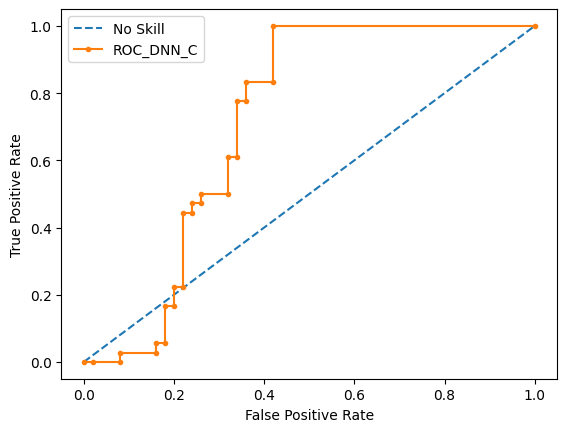

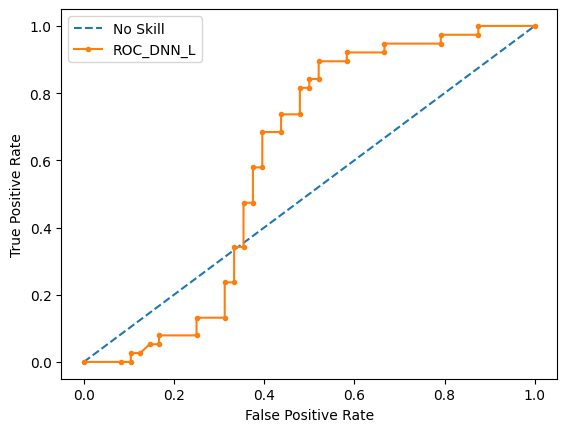

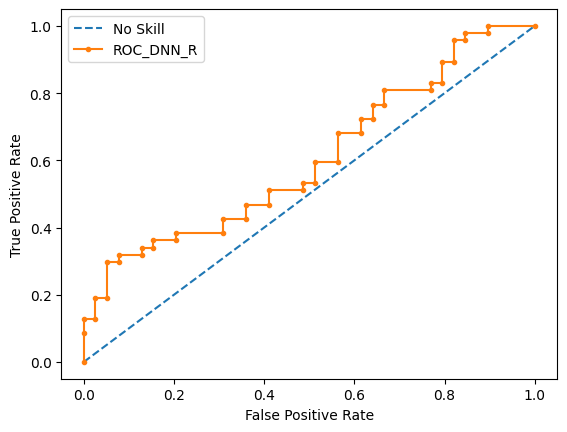

Average Precision Score for C is 0.5201630620020955


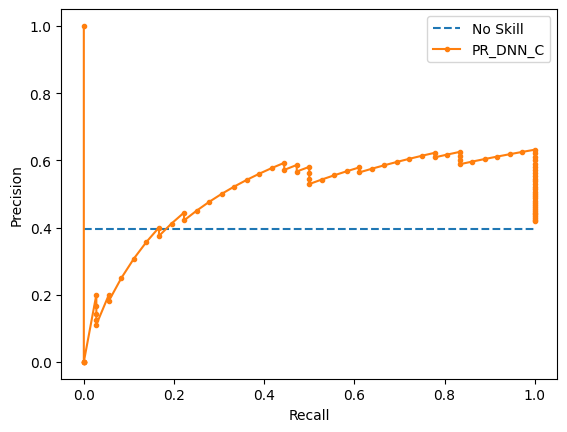

Average Precision Score for L is 0.46322449532135035


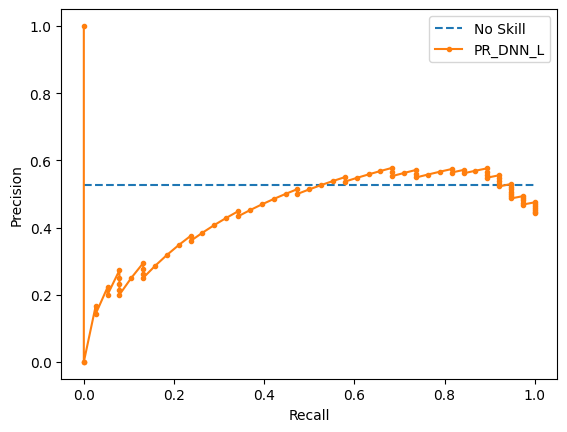

Average Precision Score for R is 0.7001511138742698


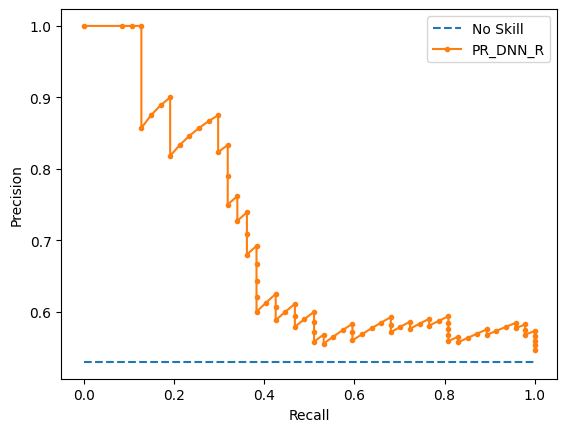

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np

# File paths and names
filename_car = "/content/drive/MyDrive/ee782_project/dataset/Data_Set_Car.xlsx"
filename_analysis = "/content/drive/MyDrive/ee782_project/dataset/Predictions_Multi_Class_Car_PR_ROC.xlsx"
filename_analysis_Keras = "/content/drive/MyDrive/ee782_project/dataset/Predictions_PR_ROC_Keras.xlsx"
filename_analysis_DNN = "/content/drive/MyDrive/ee782_project/dataset/Predictions_PR_ROC.xlsx"
metrics_file_car = "/content/drive/MyDrive/ee782_project/dataset/Metrics_File_Car.txt"

# List of features and target columns for car-related data
features = ['Flowrate', 'Speed', 'Phasetime']
data_car_columns = ['Vehicle no', 'Time 1', 'Time 2 (T1+30 sec)', 'Speed 1', 'Speed 2', 'Distance 1', 'Distance 2', 'Camera', 'Lidar', 'Radar']
target_car = ['C', 'L', 'R']
sheet_name = ['Trustworthy_Data', 'Untrustworthy_Data', 'Untrustworthy_MO']

# Function to perform final result analysis for multi-class classification
def final_result_analysis():
    print('Processing Final Results')

    # Read car-related data
    data_excel, data = read_data_car(filename_car, data_car_columns, sheet_name='data_car')

    # Read the final predictions dataframe
    df_final = pd.read_excel(filename_analysis)

    # Select relevant columns for analysis
    columns = ['C', 'L', 'R', 'C_Pred', 'L_Pred', 'R_Pred', 'C_Pred_Class', 'L_Pred_Class', 'R_Pred_Class']
    df_final = df_final[columns]

    # Model evaluation instances for ROC, PR, and metrics
    Model_Eval_ROC = Model_Evaluation_ROC("Keras_Multiclass_Classifier_Car")
    Model_Eval_PR = Model_Evaluation_PR("Keras_Multiclass_Classifier_Car")
    Model_Eval_metrics = Model_Evaluation_metrics("Keras_Multiclass_Classifier_Car")

    # Print and save evaluation metrics
    Model_Eval_metrics.metrics_printer(df_final, len(target_car), 6)
    Model_Eval_ROC.ROC_Curve_Generator_Subplot(df_final, len(target_car), 3)
    Model_Eval_metrics.metrics_file_writer(metrics_file_car, df_final, len(target_car), 6)

    # Generate PR curves with subplot for each class
    Model_Eval_PR.PR_Curve_Generator_Subplot(df_final, len(target_car), 3, data, list(data.columns).index('C'))

# Function to perform final result analysis for two-class classification using either Keras or DNN
def final_result_analysis_DNN_Keras(Model):
    print('Processing Final Results DNN all data - trust, non-trust classification')

    # Determine the filename based on the specified model
    if Model == 'Keras':
        filename_two_class = filename_analysis_Keras
    elif Model == 'DNN':
        filename_two_class = filename_analysis_DNN
    else:
        print('Wrong Method Name')
        exit()

    # Read trustworthy and untrustworthy data, and combine them
    df_tr = read_data(filename, features, target, sheet_name[0])
    df_utr = read_data(filename, features, target, sheet_name[1])
    df_combined = prepare_data(df_tr, df_utr, True)

    # Read the final predictions dataframe for two-class classification
    df_final = pd.read_excel(filename_two_class)

    # Select relevant columns for analysis
    columns = ['Target', 'Prediction', 'Class']
    df_final = df_final[columns]

    # Model evaluation instances for ROC, PR, and metrics
    Model_Eval_ROC = Model_Evaluation_ROC("Evaluating DNN classifier for trust vs non-trust")
    Model_Eval_PR = Model_Evaluation_PR("Evaluating DNN classifier for trust vs non-trust")
    Model_Eval_metrics = Model_Evaluation_metrics("Evaluating DNN classifier for trust vs non-trust")

    # Print and save evaluation metrics
    Model_Eval_metrics.metrics_printer(df_final, len(target), 2)
    Model_Eval_ROC.ROC_Curve_Generator(df_final, len(target), 1)
    Model_Eval_metrics.metrics_file_writer(metrics_file_car, df_final, len(target), 2)

    # Generate PR curves for two-class classification
    Model_Eval_PR.PR_Curve_Generator(df_final, len(target), 1, df_combined, list(df_combined.columns).index('Two_Class'))
    Model_Eval_metrics.figure_generator_single_output(df_final, len(target), 1, df_combined, list(df_combined.columns).index('Two_Class'))

# Function to perform box plot analysis
def box_plot_analysis():
    # Read the final predictions dataframe for two-class classification using Keras
    df_final = pd.read_excel(filename_analysis_Keras)

    # Read the final predictions dataframe for multi-class classification
    df_final_car = pd.read_excel(filename_analysis)

    # Select relevant columns for analysis
    columns = ['C', 'L', 'R', 'C_Pred', 'L_Pred', 'R_Pred', 'C_Pred_Class', 'L_Pred_Class', 'R_Pred_Class']
    df_final_car = df_final_car[columns]

    # Model evaluation instance for box plot analysis
    Model_Eval_boxplot = Model_Evaluation_boxplot("Evaluating DNN classifier for trust vs non-trust")

    # Specify parameters for box plot analysis
    param = ["Target", "Prediction"]

    # Generate box plots
    Model_Eval_boxplot.box_plot_generator(df_final, param, df_final_car, columns)

if __name__ == '__main__':
    # Train a multi-class classifier for car-related data and get evaluation results
    MOClassifier, data_excel, data_processed, test_df_MOC, df = Keras_multiclass_cassifier_car()

    # Uncomment and call additional analysis functions as needed
    # final_result_analysis()
    # final_result_analysis_DNN_Keras('Keras')
    # box_plot_analysis()


# Model_Comparison

<ipython-input-19-68736791a7e1>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2).reset_index(drop = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-687367

Accuracy: 0.9056603773584906
Precision: 0.847457627118644
Recall: 0.9803921568627451
Accuracy: 90.57%
4/4 [==============================] - 0s 3ms/step
Processing Final Results Comparison


<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_index = True)
<ipython-input-19-68736791a7e1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([frame], columns = columns), ignore_in

Accuracy Score for C is 0.9472687939426717
Precision Score for C is 0.9334719334719335
Recall Score for C is 0.9315352697095436
F1 Score for C is 0.932502596053998
ROC AUC Score for C is 0.9444532476434041
Confusion Matrix for C is [[2156   96]
 [  99 1347]]
Accuracy Score for L is 0.7893455922120065
Precision Score for L is 0.79493545183714
Recall Score for L is 0.8139298423995933
F1 Score for L is 0.8043205224817884
ROC AUC Score for L is 0.78766971611603
Confusion Matrix for L is [[1318  413]
 [ 366 1601]]
Accuracy Score for R is 0.7598702001081665
Precision Score for R is 0.7899947889525795
Recall Score for R is 0.7576211894052973
F1 Score for R is 0.773469387755102
ROC AUC Score for R is 0.7600716436124896
Confusion Matrix for R is [[1294  403]
 [ 485 1516]]
Accuracy Score for C is 0.8046511627906977
Precision Score for C is 0.7542857142857143
Recall Score for C is 0.7630057803468208
F1 Score for C is 0.7586206896551724
ROC AUC Score for C is 0.7978453026247722
Confusion Matrix fo

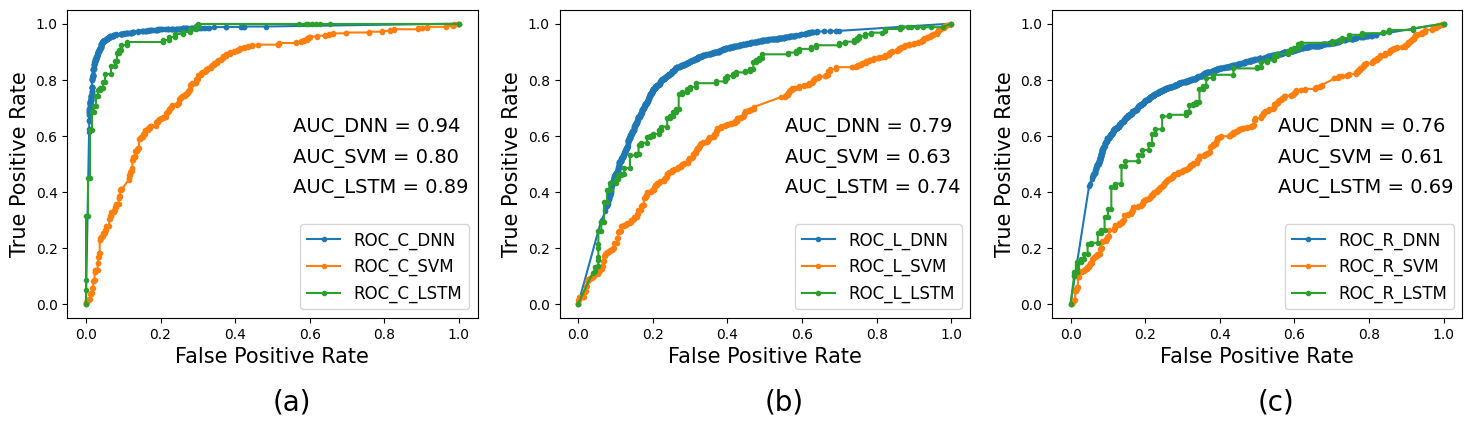

Average Precision Score for C is 0.9611724845574278
Average Precision Score for L is 0.8103663504692408
Average Precision Score for R is 0.833740173814003


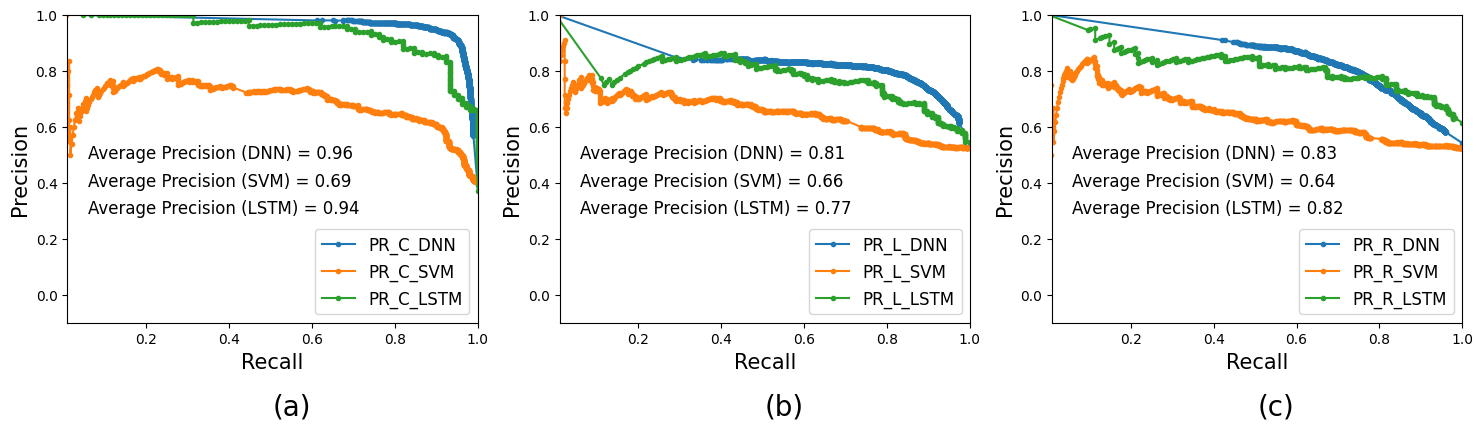

Processing Final Results DNN all data - trust, non-trust classification


<ipython-input-19-68736791a7e1>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2).reset_index(drop = True)


Accuracy Score for Target is 0.9587264150943396
Precision Score for Target is 0.9373493975903614
Recall Score for Target is 0.9773869346733668
F1 Score for Target is 0.956949569495695
ROC AUC Score for Target is 0.9598045784477944
Confusion Matrix for Target is [[848  52]
 [ 18 778]]
Accuracy Score for Target is 0.8836477987421384
Precision Score for Target is 0.851024208566108
Recall Score for Target is 0.9364754098360656
F1 Score for Target is 0.8917073170731709
ROC AUC Score for Target is 0.8824007950467883
Confusion Matrix for Target is [[386  80]
 [ 31 457]]
Accuracy Score for Target is 0.8641509433962264
Precision Score for Target is 0.8295081967213115
Recall Score for Target is 0.9267399267399268
F1 Score for Target is 0.8754325259515571
ROC AUC Score for Target is 0.8622026481948661
Confusion Matrix for Target is [[205  52]
 [ 20 253]]
Average Precision Score for Target is 0.9861681110291899


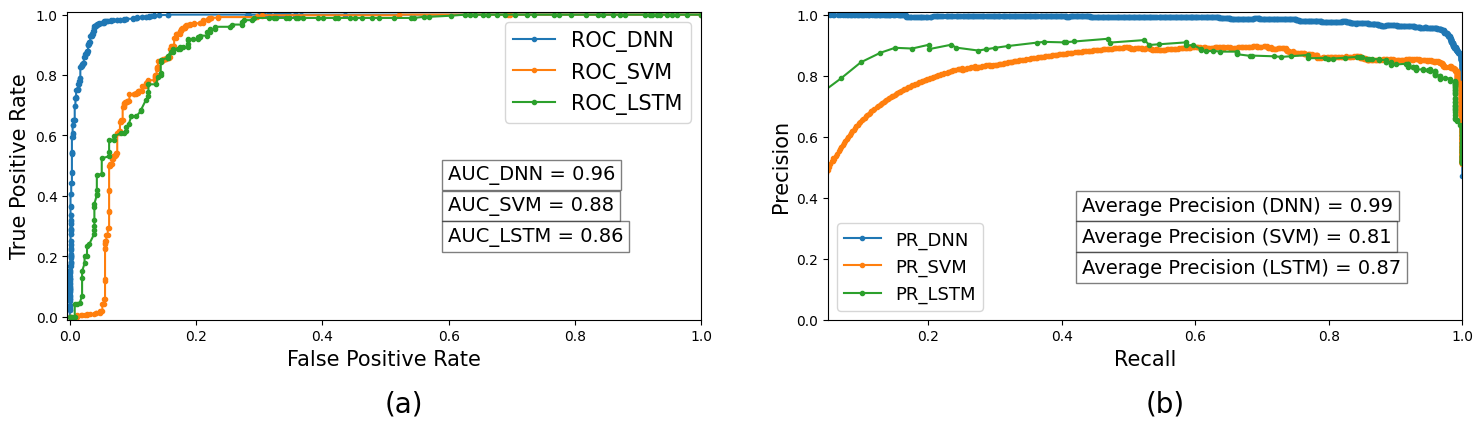

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, average_precision_score
from keras.models import Sequential
from sklearn.multiclass import OneVsRestClassifier
from keras.layers import Dense, LSTM

# Read trustworthy and untrustworthy data, and combine them
df_tr = read_data(filename, features, target, sheet_name[0])
df_utr = read_data(filename, features, target, sheet_name[1])
df_combined = prepare_data(df_tr, df_utr, True)

# Read car-related data
data_excel, data = read_data_car(filename_car, data_car_columns, sheet_name='data_car')

def SVM():
    # Split the combined data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        df_combined[features].to_numpy(),
        np.array(df_combined[target].iloc[:, 0].to_list()),
        test_size=0.2,
        random_state=109
    )

    # Create and train an SVM classifier with a polynomial kernel
    clf = svm.SVC(kernel='poly', degree=2, gamma='auto', probability=True)
    clf.fit(X_train, y_train)

    # Predictions and predicted probabilities
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    # Create a dataframe with actual, predicted, and predicted class values
    df = pd.concat([pd.DataFrame(y_test, columns=["Target"]),
                    pd.DataFrame(y_prob[:, 1], columns=['Prediction']),
                    pd.DataFrame(y_pred, columns=['Predicted_Class'])], axis=1)

    # Save predictions to an Excel file
    df.to_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_Binary_Class_SVM.xlsx", index=False)

    # Print model evaluation metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))

    return y_test, y_pred



def LSTM_Keras(keras_df, features, target, direct=1):
    # Round the dataframe values and flatten them for LSTM input
    df_LSTM = keras_df.round(1)
    list_of_Values = list(df_LSTM.iloc[:, 0])

    for i in range(len(features)):
        list_of_Values.extend(list(df_LSTM.iloc[:, i]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        df_LSTM[features].to_numpy(),
        np.array(df_LSTM[target]),
        test_size=0.2,
        random_state=109
    )

    # Create and compile an LSTM model
    model = Sequential()
    n_timesteps = 1
    n_features = len(features)
    model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Reshape training data for LSTM input
    n_samples = X_train.shape[0]
    X_train = X_train.reshape(n_samples, n_timesteps, n_features)

    # Train the LSTM model
    model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0)

    # Reshape testing data for LSTM input
    n_samples = X_test.shape[0]
    X_test = X_test.reshape(n_samples, n_timesteps, n_features)

    # Evaluate the LSTM model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    # Generate predictions and predicted probabilities
    prediction = model.predict(X_test)
    prediction = pd.DataFrame(prediction, columns=['Predicted_Class'])
    prediction = prediction.gt(0.5).astype(int)
    predicted_probability = model.predict(X_test)

    # Concatenate actual, predicted probabilities, and predicted class values
    df = pd.concat([pd.DataFrame(y_test, columns=["Target"]),
                    pd.DataFrame(predicted_probability, columns=['Prediction']),
                    prediction], axis=1)

    # Save predictions to an Excel file
    if direct == 1:  # calling only for car trustworthiness:
        df.to_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_Binary_Class_LSTM.xlsx", index=False)
    else:
        df.to_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_Sensors_LSTM_" + target + ".xlsx", index=False)

def final_result_analysis_sensors_comparison():
    # Compare results of Keras, SVM, and LSTM models for car trustworthiness
    print('Processing Final Results Comparison')
    data_excel, data = read_data_car(filename_car, data_car_columns, sheet_name='data_car')
    df_final = pd.read_excel(filename_analysis)
    df_final_SVM = pd.read_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_Multi_Class_SVM_PR_ROC_Poly_2.xlsx")
    df_final_LSTM = pd.read_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_Multi_Class_LSTM_PR_ROC.xlsx")

    columns = ['C', 'L', 'R', 'C_Pred', 'L_Pred', 'R_Pred', 'C_Pred_Class', 'L_Pred_Class', 'R_Pred_Class']

    df_final = df_final[columns]
    df_final_SVM = df_final_SVM[columns]
    df_final_LSTM = df_final_LSTM[columns]

    Model_Eval_metrics = Model_Evaluation_metrics("Keras_Multiclass_Classifier_Car")
    Model_Eval_ROC = Model_Evaluation_ROC("Keras_Multiclass_Classifier_Car")
    Model_Eval_PR = Model_Evaluation_PR("Keras_Multiclass_Classifier_Car")

    Model_Eval_metrics.metrics_printer(df_final, len(target_car), 6)
    Model_Eval_metrics.metrics_printer(df_final_SVM, len(target_car), 6)
    Model_Eval_metrics.metrics_printer(df_final_LSTM, len(target_car), 6)
    Model_Eval_ROC.ROC_Curve_Generator_Subplot_Comparison(df_final, df_final_SVM, df_final_LSTM, len(target_car), 3)

    Model_Eval_PR.PR_Curve_Generator_Subplot_Comparison(df_final, df_final_SVM, df_final_LSTM, len(target_car), 3, data, list(data.columns).index('C'))

def final_result_analysis_comparison():
    # Compare results of Keras, SVM, and LSTM models for trust vs non-trust classification
    print('Processing Final Results DNN all data - trust, non-trust classification')

    df_tr = read_data(filename, features, target, sheet_name[0])
    df_utr = read_data(filename, features, target, sheet_name[1])
    df_combined = prepare_data(df_tr, df_utr, True)

    df_final = pd.read_excel(filename_analysis_Keras)
    df_final_SVM = pd.read_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_PR_ROC_SVM_Poly_2.xlsx")
    df_final_LSTM = pd.read_excel("/content/drive/MyDrive/ee782_project/dataset/Predictions_PR_ROC_LSTM.xlsx")

    columns = ['Target', 'Prediction', 'Class']
    df_final = df_final[columns]
    df_final_SVM = df_final_SVM[columns]
    df_final_LSTM = df_final_LSTM[columns]

    Model_Eval_metrics = Model_Evaluation_metrics("Evaluating DNN classifier for trust vs non-trust")
    Model_Eval_ROC = Model_Evaluation_ROC("Evaluating DNN classifier for trust vs non-trust")
    Model_Eval_PR = Model_Evaluation_PR("Evaluating DNN classifier for trust vs non-trust")

    Model_Eval_metrics.metrics_printer(df_final, len(target), 2)
    Model_Eval_metrics.metrics_printer(df_final_SVM, len(target), 2)
    Model_Eval_metrics.metrics_printer(df_final_LSTM, len(target), 2)
    Model_Eval_metrics.figure_generator_single_output_comparison(df_final, df_final_SVM, df_final_LSTM, len(target), 1, df_combined, list(df_combined.columns).index('Two_Class'))

if __name__ == '__main__':
    # Uncomment and run additional functions as needed
    SVM()
    LSTM_Keras(df_combined, features, target)
    #SVM_Multilevel()
    #LSTM_Keras_Multilevel()
    final_result_analysis_sensors_comparison()
    final_result_analysis_comparison()


# Challenges Faced
- There is lot of data to be kept track on and check whether the predicted data previously is given correctly to the final comparison testing
- Checking and runnin the data for all different scenarios(4 scenarios of malfunctioning of components as mentioned in the report) is a challenging process
- Need to calculate the parameters that impact the relation between the cars and the traffic conditions for a large amount of data and add all this predicted data into single file for comparison in SVM and LSTM